# Prroject Variational Autoencoders FashionMNIST


- Deep Learning for Computer Vision - Winter Term 2024/25
- Lecture by: Constantin Pape
- Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair
- Due date: **Tuesday, Jan 14, before 10:00**

In this Projrct a variational autoencoder (VAE) shall be implemented and trained on the fashion MNIST dataset. VAEs are an example of generative deep learning and can be used to synthesize data - images in this case - which shall also be demonstrated in this exercise!

### IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all the questions in written form**
- When you're done, download the notebook and **rename** it to ```<surname1>_<surname2>_<surname3>.ipynb```
- Only submit the Jupyter Notebook (.ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 5` -> `Tutorial X` (where, X is the tutorial you are assigned to).
- Make only one submission of the exercise per group.
- The deadline is strict
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

### TASKS
* TASK 1: Implement a VAE
* TASK 2: Train the model and plot train and test set loss over training in the same plot
* TASK 3: Determine optimal dimensionality of latent space
* TASK 4: Plot some latent traversals
* TASK 5: Visualize class labels in latent space

## Setup and Requirements

### Imports

In [ ]:
from __future__ import print_function
import pathlib

import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils

import numpy as np

!nvcc --version
!python --version
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Python 3.10.12
2.5.1+cu121


### Basic setup

Define various global parameters used throughout the notebook!

In [ ]:
# Try to use GPU if available
use_cuda = True

# Path for data
data_dir = pathlib.Path('data/')

# Batch size
batch_size = 128

# Image size (same size in both dimensions)
image_size = 28

# Dimension of the latent space
latent_space_dim = 10

# Number of epochs to train
epochs = 5

# How many batches to skip before logging training status
log_interval = 100

# Exponential averaging factor for loss graphs
exp_average_factor = 0.90

# Define beta (weighting of regularization loss)
beta = 1

# Channels in the convolutional layers
capacity = 32

# Learning rate for the optimizer
learning_rate = 1e-3

# Define size / zoom level of plots
plot_zoom = 2
plot_w, plot_h = plt.figure().get_size_inches()
plot_w = plot_w * plot_zoom; plot_h = plot_h * plot_zoom;

<Figure size 640x480 with 0 Axes>

Test if a GPU (CUDA) is available in the environment and use it if it is. Otherwise use the CPU.

In [ ]:
if use_cuda and not torch.cuda.is_available():
    print("Error: cuda requested but not available, will use cpu instead!")
    device = torch.device('cpu')

elif not use_cuda:
    print("Info: will use cpu!")
    device = torch.device('cpu')

else:
    print("Info: cuda requested and available, will use gpu!")
    device = torch.device('cuda')



Info: cuda requested and available, will use gpu!


## Get and preprocess the data


We will use the FashionMNIST data set from Zalando (https://github.com/zalandoresearch/fashion-mnist) for our experiments.  
From the quoted github-repo: "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."


### Load the data for training and testing

The FashionMNIST dataset is already included in the torchvision datasets with the approriate training and test splits. Run the cell below to use it in this notebook.

In [ ]:
# TODO: Load the datasets
# Here, we convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL images or numpy arrays to torch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor with mean=0.5 and std=0.5
])

train_dataset = datasets.FashionMNIST(
    root='./data',            # Directory to store the dataset
    train=True,               # Specify that we want the training set
    download=True,            # Download the dataset if it's not already present
    transform=transform       # Apply the defined transformations
)

# Load the test dataset
test_dataset = datasets.FashionMNIST(
    root='./data',            # Directory to store the dataset
    train=False,              # Specify that we want the test set
    download=True,            # Download the dataset if it's not already present
    transform=transform       # Apply the defined transformations
)

For comparison, you can also use the well known MNIST dataset, which is also already included in the torchvision datasets with the approriate training and test splits. Just run the cell included in the appendix instead if you want to use it in this notebook.

Define data loaders for the training and test sets which return batches of samples.

In [ ]:
# TODO: Define the data loaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Plot the data

To get an impression of the dataset plot some random exemplary pictures.

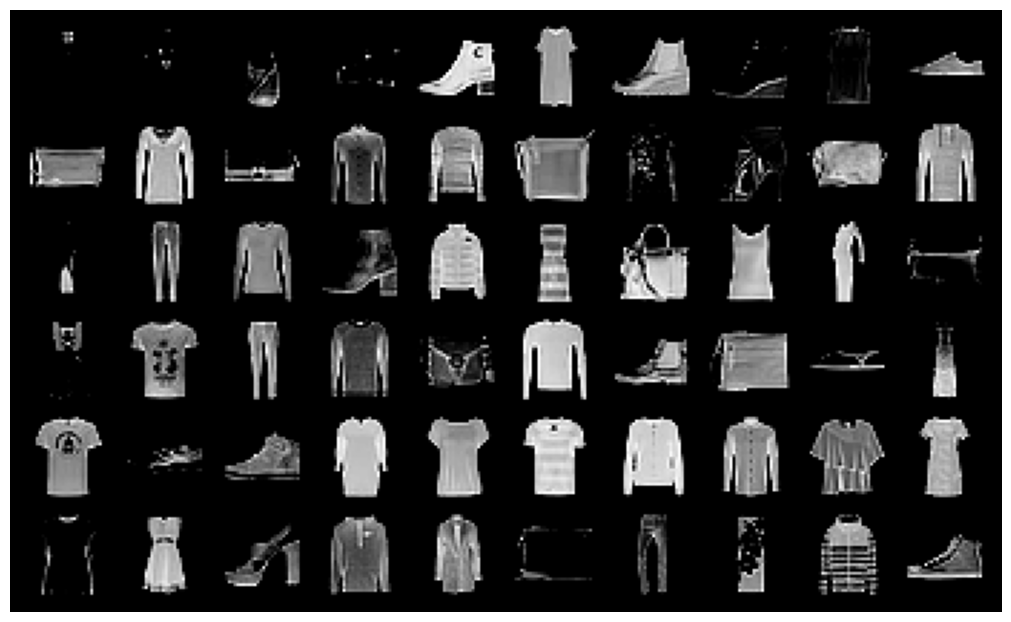

In [ ]:
images_columns = 10
images_rows = 6

def show_grid(images_tensor, images_columns, images_rows):
    image = torchvision.utils.make_grid(images_tensor, images_columns, images_rows)
    image = image.numpy()
    fig = plt.gcf()
    fig.set_size_inches(plot_w, plot_h)
    plt.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

data_iterator = iter(train_loader)
images, labels = next(data_iterator)

show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

## Implement a VAE neural network architecture

### Implement the network architecture

Recall that a VAE roughly consistst of two parts: The encoder (which reduces the number of dimensions and maps the input to the latent space) and the decoder (which reverses the encoding, mapping from the latent space back to the initial space).

In VAEs (compared to standard auto-encoders) we assume that the latent space is generated from a multi-variate normal distribution (N~(μ, σ²)) that is parameterized by two vectors, mean and variance. In the network, we use the log of the variance.

In training, we sample from the distribution using the current values of the two vectors, which are updated in each step. After training, we use the mu value to draw the samples.

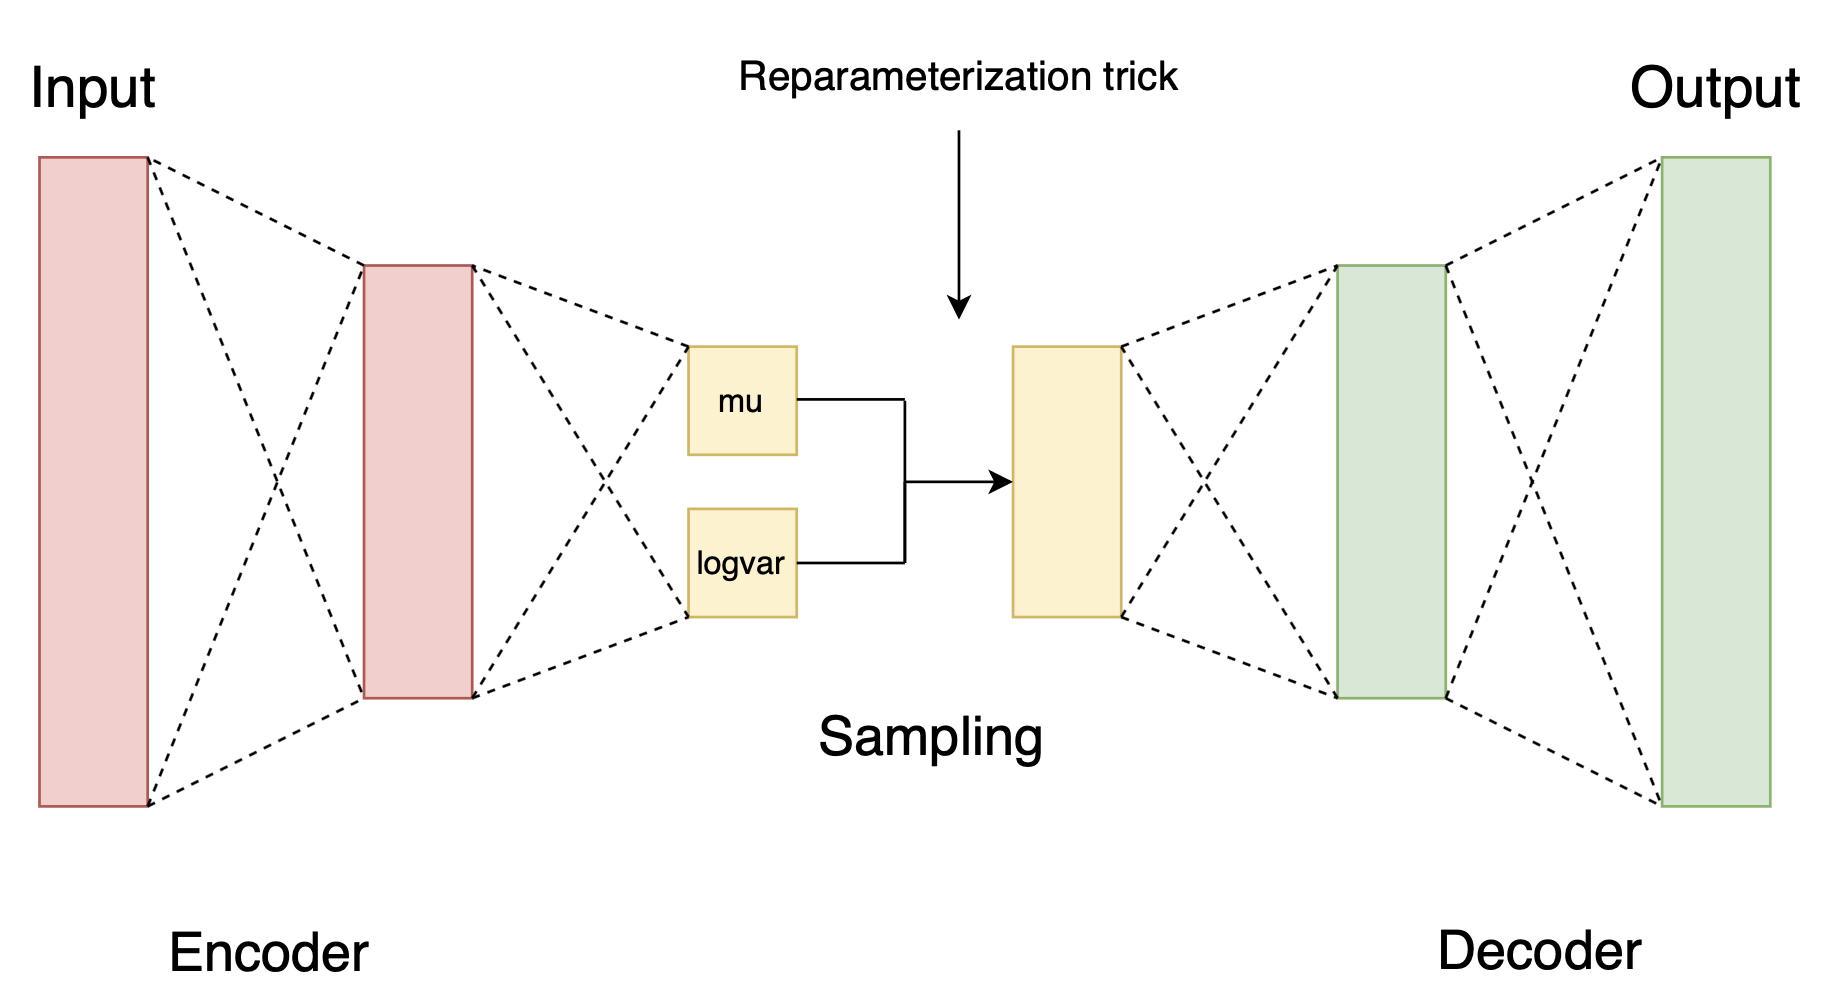

**TASK 1: Implement a VAE with the following network architecture**

We will implement a basic convolutional VAE architecture. Look at the following VAE class specification and implement it accordingly:

**Encoder (sequential model):**
 * Convolutional Layer with (1, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * Convolutional Layer with (capacity, 2 * capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer

**Sampling:**
* mu, logvar: Linear Layer with 2 * capacity * 7 * 7 input features and latent_dims output features each
* z: Linear Layer with latent_dims input features and 2 * capacity * 7 * 7 output features

**Decoder (sequential model):**
 * ConvTranspose2d Layer with (2 * capacity, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * ConvTranspose2d Layer with (capacity, 1) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * Sigmoid Activation Layer



**Hint**

For the sampling use the reparameterization trick:

To generate x ~ N(μ, σ²), sample ε ~ N(0, 1). Then x can be computed as x = μ + σε.

Further, remember to differentiate between training and eval: sample in training and return mu in eval.

**TODO** What does the trick do and why do we need it?

**Your answer here:**   sampling directly from N(μ, σ²) introduces randomness that makes the sampling operation non-differentiable. This non-differentiability blocks the flow of gradients from the loss function back through the encoder during training, preventing the model from learning the optimal parameters.
                        Instead of sampling z directly from N(μ, σ²), first sample ε from a standard normal distribution N(0, 1).
Compute z using the sampled ε and the encoder's outputs μ and σ (where σ is the standard deviation, obtained by taking the square root of the variance σ²):
z=μ+σ⋅ϵ
This transformation ensures that z is now a differentiable function of μ and σ.
Since ε is independent of μ and σ, and the operations involved are differentiable, gradients can now flow through μ and σ during backpropagation.

In [ ]:
# TODO Implement the VAE
class VAE(nn.Module):
    def __init__(self, capacity=32, latent_dim=10):
        """
        Initializes the VAE model.

        Args:
            capacity (int): Base number of channels for convolutional layers.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(VAE, self).__init__()
        self.capacity = capacity
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=capacity,
                kernel_size=4,
                stride=2,
                padding=1
            ),  # Output: (capacity, 14, 14)
            nn.ReLU(),
            nn.Conv2d(
                in_channels=capacity,
                out_channels=2 * capacity,
                kernel_size=4,
                stride=2,
                padding=1
            ),  # Output: (2*capacity, 7, 7)
            nn.ReLU()
        )

        # Compute the size after convolution layers to flatten
        self.flatten_dim = 2 * capacity * 7 * 7

        # Latent space
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_z = nn.Linear(latent_dim, self.flatten_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=2 * capacity,
                out_channels=capacity,
                kernel_size=4,
                stride=2,
                padding=1
            ),  # Output: (capacity, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=capacity,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=1
            ),  # Output: (1, 28, 28)
            nn.Sigmoid()  # To ensure output is between 0 and 1
        )

    def encode(self, x):
        """
        Encodes the input by passing through the encoder network and returns
        the latent mean and log variance.

        Args:
            x (Tensor): Input tensor of shape (batch_size, 1, 28, 28)

        Returns:
            mu (Tensor): Mean of the latent Gaussian
            logvar (Tensor): Log variance of the latent Gaussian
        """
        encoded = self.encoder(x)  # Shape: (batch_size, 2*capacity, 7, 7)
        encoded = encoded.view(-1, self.flatten_dim)  # Flatten
        mu = self.fc_mu(encoded)  # Shape: (batch_size, latent_dims)
        logvar = self.fc_logvar(encoded)  # Shape: (batch_size, latent_dims)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).

        Args:
            mu (Tensor): Mean of the latent Gaussian
            logvar (Tensor): Log variance of the latent Gaussian

        Returns:
            z (Tensor): Sampled latent vector
        """
        std = torch.exp(0.5 * logvar)  # Calculate the standard deviation
        eps = torch.randn_like(std)  # Sample epsilon from N(0,1)
        z = mu + std * eps  # Sampled latent vector
        return z

    def decode(self, z):
        """
        Decodes the latent vector by passing through the decoder network.

        Args:
            z (Tensor): Latent vector of shape (batch_size, latent_dims)

        Returns:
            recon_x (Tensor): Reconstructed input
        """
        z = self.fc_z(z)  # Shape: (batch_size, 2*capacity*7*7)
        z = z.view(-1, 2 * self.capacity, 7, 7)  # Reshape to (batch_size, 2*capacity, 7, 7)
        recon_x = self.decoder(z)  # Shape: (batch_size, 1, 28, 28)
        return recon_x

    def forward(self, x):
        """
        Forward pass through the VAE.

        Args:
            x (Tensor): Input tensor of shape (batch_size, 1, 28, 28)

        Returns:
            recon_x (Tensor): Reconstructed input
            mu (Tensor): Mean of the latent Gaussian
            logvar (Tensor): Log variance of the latent Gaussian
        """
        mu, logvar = self.encode(x)
        if self.training:
            z = self.reparameterize(mu, logvar)
        else:
            z = mu  # Use mu directly during evaluation
        recon_x = self.decode(z)
        return recon_x, mu, logvar


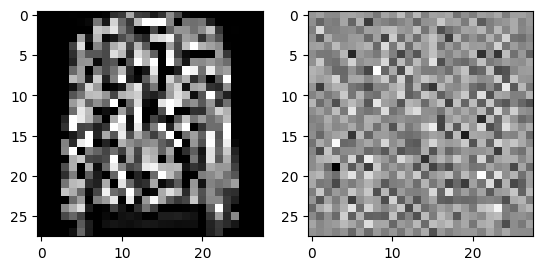

In [ ]:
latent_dim=10
capacity=32
model = VAE(capacity,latent_dim).to(device)
images,_ = next(iter(train_loader))

images = images.to(device)
out,mean,logvar = model(images)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.transpose(images[0].cpu(), (1, 2, 0)), cmap = "gray")
axarr[1].imshow(out[0].cpu().detach().numpy().squeeze(), cmap = "gray")

### Implement the loss function

Implement the two parts of the loss function: reconstruction loss using Mean Squared Error (MSE) function and the regularization part of the loss using Kullback-Leibler-Divergence (KLD).

**Hint:**
- Make sure that you use sum instead of mean for calculating the MSE loss!
- Refer to the paper _Auto-Encoding Variational Bayes_ by Kingma and Welling to implement the loss function.

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and
    # summed over all elements and batch
    mse_loss = F.mse_loss(recon_x, x, reduction='sum')  # TODO

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # TODO

    total_loss = mse_loss + kld_loss

    return total_loss, mse_loss, kld_loss

### Instantiate the model and define the optimizer to use.

In [ ]:
capacity = 32       # Base number of channels in convolutional layers
latent_dim = 10   # Dimensionality of the latent space
model = VAE(capacity=capacity, latent_dim=latent_dim).to(device).float()  # TODO: Instantiate the VAE model
learning_rate = 1e-3
# Instantiate the optimizer with the model's parameters and the defined learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # TODO

In [ ]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=10, bias=True)
  (fc_z): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

## Train the network

**TASK 2: Train the model and plot train+test set loss over training in the same plot using the given `plot_losses` function**


In [ ]:
def plot_losses(
    train_total_losses=None, train_mse_losses=None, train_kld_losses=None,
    test_epoch_total_losses=None, test_epoch_mse_losses=None, test_epoch_kld_losses=None
):
    x = range(1, len(train_total_losses) + 1)
    train_batches = len(train_loader)

    # set line colors
    train_color_mse   = 'moccasin'
    train_color_kld   = 'skyblue'
    train_color_total = 'palegreen'

    test_color_mse   = 'orange'
    test_color_kld   = 'blue'
    test_color_total = 'green'

    # create figure
    fig, ax1 = plt.subplots()
    fig.set_size_inches(plot_w+2, plot_h)

    # Create total / mse loss axis
    ax1.set_xlabel("Batches (Epoch)")
    ax1.set_ylabel("Total / MSE loss")
    ax1.grid(visible=True, axis='x', linestyle=':')
    ax1.set_xticks(np.arange(0, epochs * train_batches, train_batches))
    labels = [f'{str(item)} ({index})' for index, item in enumerate(ax1.get_xticks().tolist())]
    ax1.set_xticklabels(labels)

    # Plot train-set losses
    ax1.plot(x, train_mse_losses, label="Train reconstruction loss (MSE)", color=train_color_mse)
    ax1.plot(np.nan, label = 'Train regularization loss (KLD)', color=train_color_kld) # add legend entry for KLD
    ax1.plot(x, train_total_losses, label="Train total loss", color=train_color_total)

    # Compute test-set epoch average losses
    test_total_losses=[]; test_mse_losses=[]; test_kld_losses=[]
    for epoch in range(epochs):
        test_total_losses += [test_epoch_total_losses[epoch] for i in range(train_batches)]
        test_mse_losses   += [test_epoch_mse_losses[epoch] for i in range(train_batches)]
        test_kld_losses   += [test_epoch_kld_losses[epoch] for i in range(train_batches)]

    # Plot test-set losses
    ax1.plot(x, test_mse_losses, label="Test reconstruction loss (MSE)", color=test_color_mse)
    ax1.plot(np.nan, label = 'Test regularization loss (KLD)', color=test_color_kld) # add legend entry for KLD
    ax1.plot(x, test_total_losses, label="Test total loss", color=test_color_total)


    # Create kld loss twin axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("KLD loss")
    ax2.plot(x, train_kld_losses, label="Train regularization loss (KLD)", color=train_color_kld)
    ax2.plot(x, test_kld_losses, label="Test regularization loss (KLD)", color=test_color_kld)

    ax1.legend(loc='center right', framealpha=1, bbox_to_anchor=(1.3, 0.5))

    fig.tight_layout()
    plt.show()

In [ ]:
import torch

def train_model(
    model,
    optimizer,
    loss_function,
    train_loader,
    test_loader,
    device,
    epochs=20,
    print_interval=100
):

    # Initialize loss tracking lists
    train_total_losses = []
    train_mse_losses = []
    train_kld_losses = []

    test_epoch_total_losses = []
    test_epoch_mse_losses = []
    test_epoch_kld_losses = []

    # Determine the number of batches per epoch
    train_batches = len(train_loader)

    for epoch in range(epochs):
        model.train()
        epoch_train_total_loss = 0.0
        epoch_train_mse_loss = 0.0
        epoch_train_kld_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader, 1):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, logvar = model(data)

            # Compute loss
            loss, mse, kld = loss_function(recon_batch, data, mu, logvar)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate epoch losses
            epoch_train_total_loss += loss.item()
            epoch_train_mse_loss += mse.item()
            epoch_train_kld_loss += kld.item()

            # Record per-batch losses
            train_total_losses.append(loss.item())
            train_mse_losses.append(mse.item())
            train_kld_losses.append(kld.item())

            # Print progress
            if batch_idx % print_interval == 0 or batch_idx == len(train_loader):
                current_loss = loss.item() / len(data)
                print(
                    f'Epoch [{epoch + 1}/{epochs}] '
                    f'Batch [{batch_idx}/{len(train_loader)}] '
                    f'Loss: {current_loss:.4f}'
                )

        # Compute average training losses for the epoch
        avg_train_total_loss = epoch_train_total_loss / len(train_loader.dataset)
        avg_train_mse_loss = epoch_train_mse_loss / len(train_loader.dataset)
        avg_train_kld_loss = epoch_train_kld_loss / len(train_loader.dataset)

        # Evaluation on test set
        model.eval()
        epoch_test_total_loss = 0.0
        epoch_test_mse_loss = 0.0
        epoch_test_kld_loss = 0.0

        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, mse, kld = loss_function(recon_batch, data, mu, logvar)

                epoch_test_total_loss += loss.item()
                epoch_test_mse_loss += mse.item()
                epoch_test_kld_loss += kld.item()

        # Compute average testing losses for the epoch
        avg_test_total_loss = epoch_test_total_loss / len(test_loader.dataset)
        avg_test_mse_loss = epoch_test_mse_loss / len(test_loader.dataset)
        avg_test_kld_loss = epoch_test_kld_loss / len(test_loader.dataset)

        # Append per-epoch test losses
        test_epoch_total_losses.append(avg_test_total_loss)
        test_epoch_mse_losses.append(avg_test_mse_loss)
        test_epoch_kld_losses.append(avg_test_kld_loss)

        # Print epoch summary
        print(
            f'====> Epoch: {epoch + 1} Average Train Loss: {avg_train_total_loss:.4f}, '
            f'MSE: {avg_train_mse_loss:.4f}, KLD: {avg_train_kld_loss:.4f}'
        )
        print(
            f'====> Epoch: {epoch + 1} Average Test Loss: {avg_test_total_loss:.4f}, '
            f'MSE: {avg_test_mse_loss:.4f}, KLD: {avg_test_kld_loss:.4f}'
        )
        print('-' * 80)  # Separator for readability

    # Compile all losses into a dictionary
    loss_history = {
        'train_total_losses': train_total_losses,       # Per-batch
        'train_mse_losses': train_mse_losses,           # Per-batch
        'train_kld_losses': train_kld_losses,           # Per-batch
        'test_epoch_total_losses': test_epoch_total_losses,  # Per-epoch
        'test_epoch_mse_losses': test_epoch_mse_losses,      # Per-epoch
        'test_epoch_kld_losses': test_epoch_kld_losses,      # Per-epoch
    }

    return loss_history


In [ ]:
def expand_test_losses(test_epoch_losses, train_batches, epochs):
    expanded_losses = []
    for epoch in range(epochs):
        expanded_losses.extend([test_epoch_losses[epoch]] * train_batches)
    return expanded_losses


In [ ]:
epochs = 5
loss_history = train_model(
    model=model,
    optimizer=optimizer,
    loss_function=vae_loss,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=epochs,
    print_interval=100
)


Epoch [1/5] Batch [100/469] Loss: 518.5513
Epoch [1/5] Batch [200/469] Loss: 500.6677
Epoch [1/5] Batch [300/469] Loss: 507.2338
Epoch [1/5] Batch [400/469] Loss: 498.1976
Epoch [1/5] Batch [469/469] Loss: 480.9665
====> Epoch: 1 Average Train Loss: 521.8609, MSE: 508.7823, KLD: 13.0786
====> Epoch: 1 Average Test Loss: 485.8599, MSE: 476.1019, KLD: 9.7580
--------------------------------------------------------------------------------
Epoch [2/5] Batch [100/469] Loss: 491.3911
Epoch [2/5] Batch [200/469] Loss: 487.1684
Epoch [2/5] Batch [300/469] Loss: 484.1011
Epoch [2/5] Batch [400/469] Loss: 486.0439
Epoch [2/5] Batch [469/469] Loss: 497.2102
====> Epoch: 2 Average Train Loss: 487.7116, MSE: 478.1669, KLD: 9.5447
====> Epoch: 2 Average Test Loss: 480.5268, MSE: 470.9673, KLD: 9.5595
--------------------------------------------------------------------------------
Epoch [3/5] Batch [100/469] Loss: 468.9813
Epoch [3/5] Batch [200/469] Loss: 484.1149
Epoch [3/5] Batch [300/469] Loss: 4

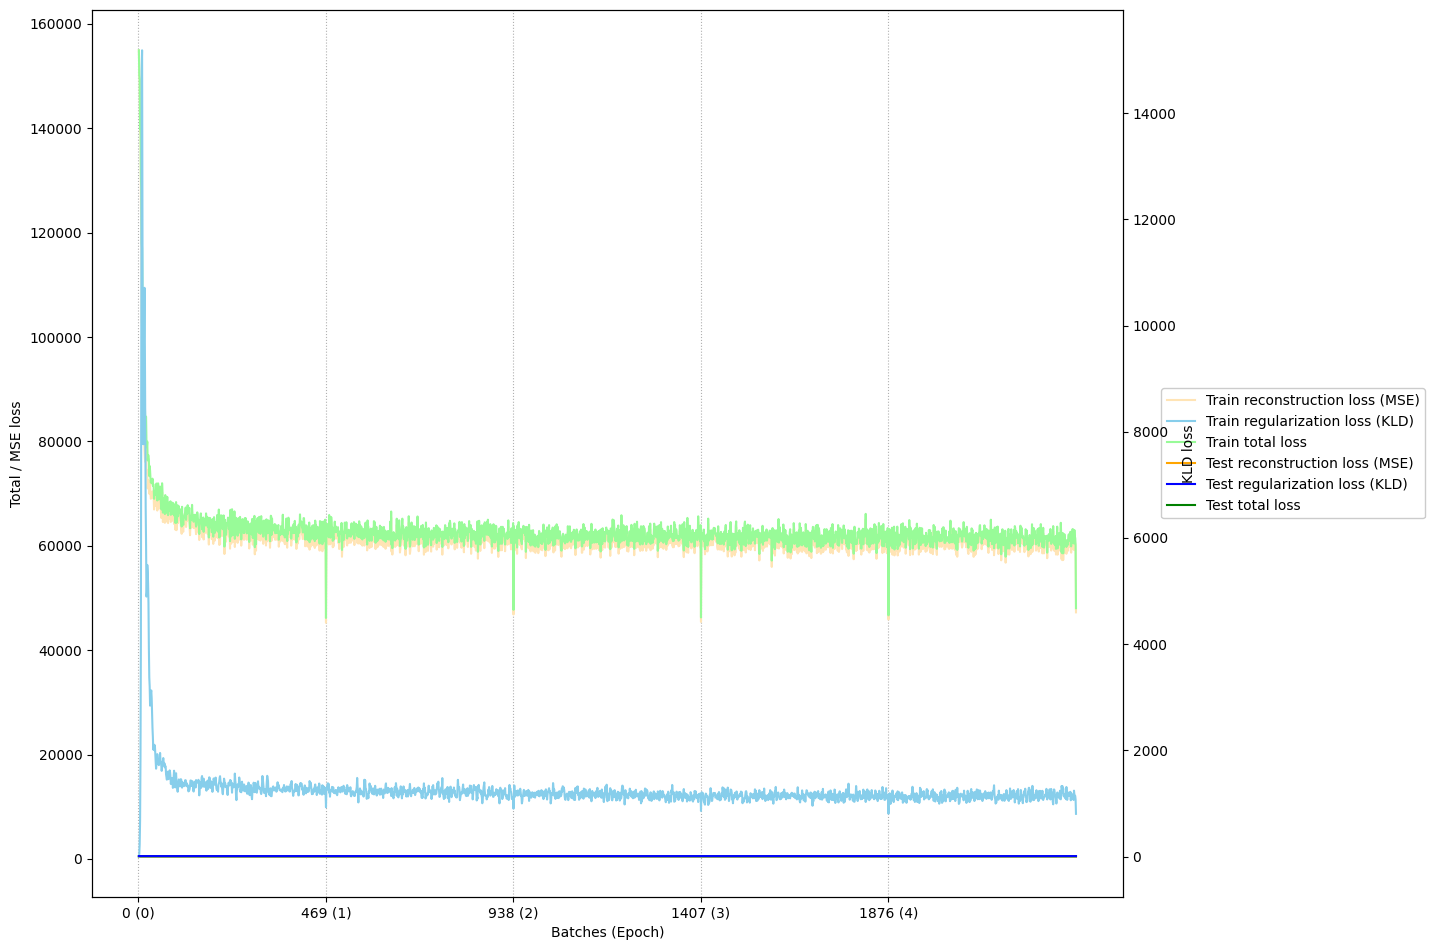

In [ ]:
# After training, expand the test losses
expanded_test_total_losses = expand_test_losses(
    loss_history['test_epoch_total_losses'],
    train_batches=len(train_loader),
    epochs=epochs
)

expanded_test_mse_losses = expand_test_losses(
    loss_history['test_epoch_mse_losses'],
    train_batches=len(train_loader),
    epochs=epochs
)

expanded_test_kld_losses = expand_test_losses(
    loss_history['test_epoch_kld_losses'],
    train_batches=len(train_loader),
    epochs=epochs
)

# Now, call plot_losses with all required parameters
plot_losses(
    train_total_losses=loss_history['train_total_losses'],       # Per-batch
    train_mse_losses=loss_history['train_mse_losses'],           # Per-batch
    train_kld_losses=loss_history['train_kld_losses'],           # Per-batch
    test_epoch_total_losses=expanded_test_total_losses,          # Expanded to per-batch
    test_epoch_mse_losses=expanded_test_mse_losses,              # Expanded to per-batch
    test_epoch_kld_losses=expanded_test_kld_losses,              # Expanded to per-batch
)


In [ ]:
!pip install utils

In [ ]:
# TODO Train and test the model
import utils
from utils import *
import tqdm

In [ ]:
def train_epoch(model, loader, loss, metric, optimizer):
    model.train()
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        pred,mu,logvar = model(x.float())
        pred,x = pred.float().squeeze(),x.float().squeeze()
        #print(pred.shape)
        #print(y.shape)
        total,mse,kld = loss(pred, x, mu, logvar)
        (total).backward()
        optimizer.step()
        if metric is not None:
            metric_value = metric(pred, y)

# run the whole training
def run_training(
    model, train_loader, loss, optimizer, n_epochs,  metric=None
):
    epoch_len = len(train_loader)
    step = 0
    for epoch in tqdm.trange(n_epochs):
        train_epoch(model, train_loader, loss, metric, optimizer)
        step = epoch_len * (epoch + 1)
    return model

run_training(model, train_loader, vae_loss, optimizer, epochs)

100%|██████████| 5/5 [01:16<00:00, 15.20s/it]


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=10, bias=True)
  (fc_z): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

### Visualization of random samples from the latent space via decoding

Here we just create a number of random samples from the latent space and use the decoder to generate images from them. Rerun the code cell to generate new samples every time!

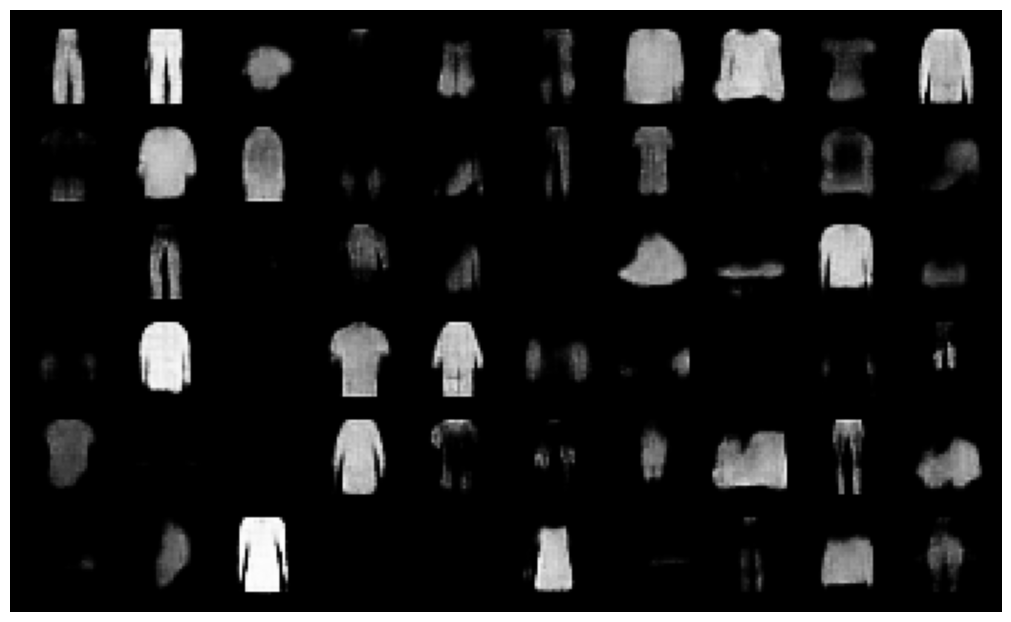

In [ ]:
with torch.no_grad():
    samples = torch.randn(images_columns * images_rows, latent_dim).to(device)
    samples = model.decode(samples).cpu()

    show_grid(samples[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualization of image reconstructions

Visualize the image reconstruction process and compare the reconstructions to the original images.

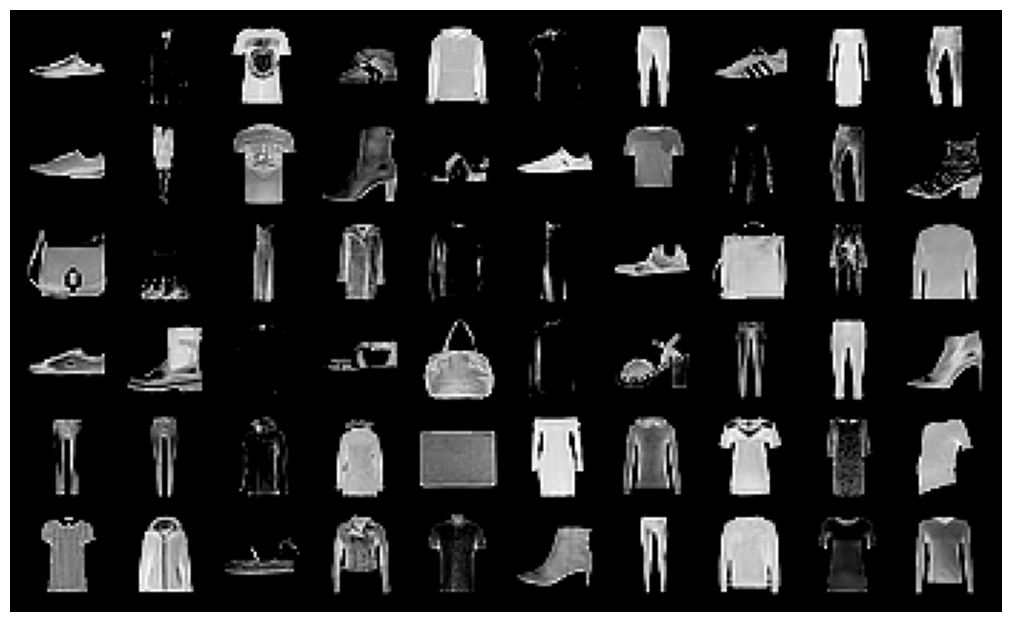

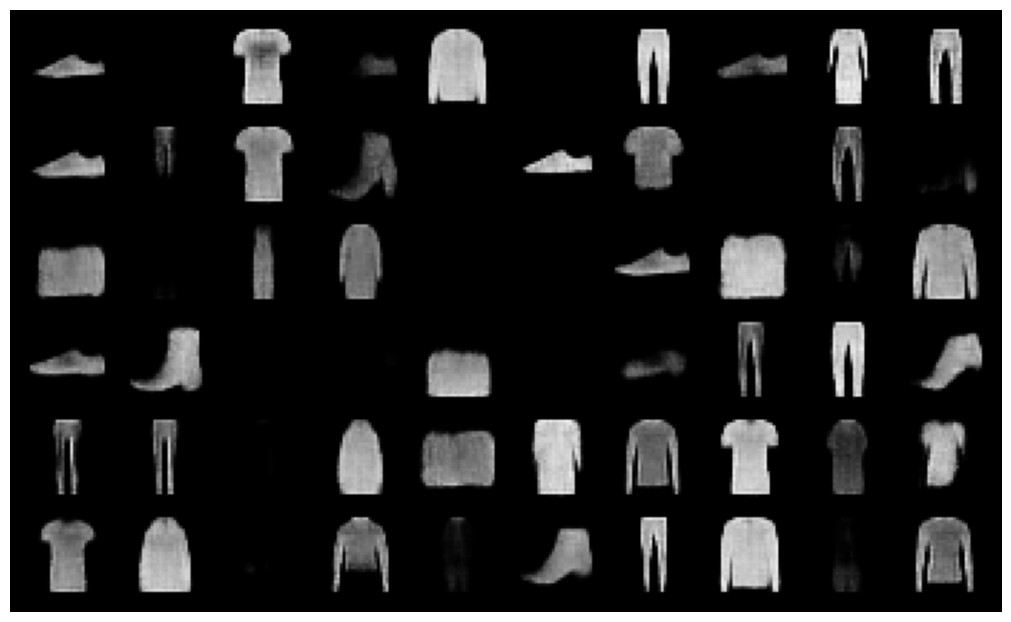

In [ ]:
images_columns = 10
images_rows    = 6

data_iterator = iter(train_loader)
images, labels = data_iterator._next_data()

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction
    images_recon,mean,logvar = model(images.to(device))

    show_grid(images_recon[0:(images_columns * images_rows)].cpu(), images_columns, images_rows)

### Optimization

**TASK 3: Explore dimensionality of latent space**

How does the dimensionality of latent space (set to 10 by default in our case) affect loss and quality of the reconstructions? Explore smaller and larger latent dimensionality by using 2, 4, 8, 16, 32 dimensions and looking at reconstructions and resulting test set losses.

100%|██████████| 10/10 [02:26<00:00, 14.62s/it]


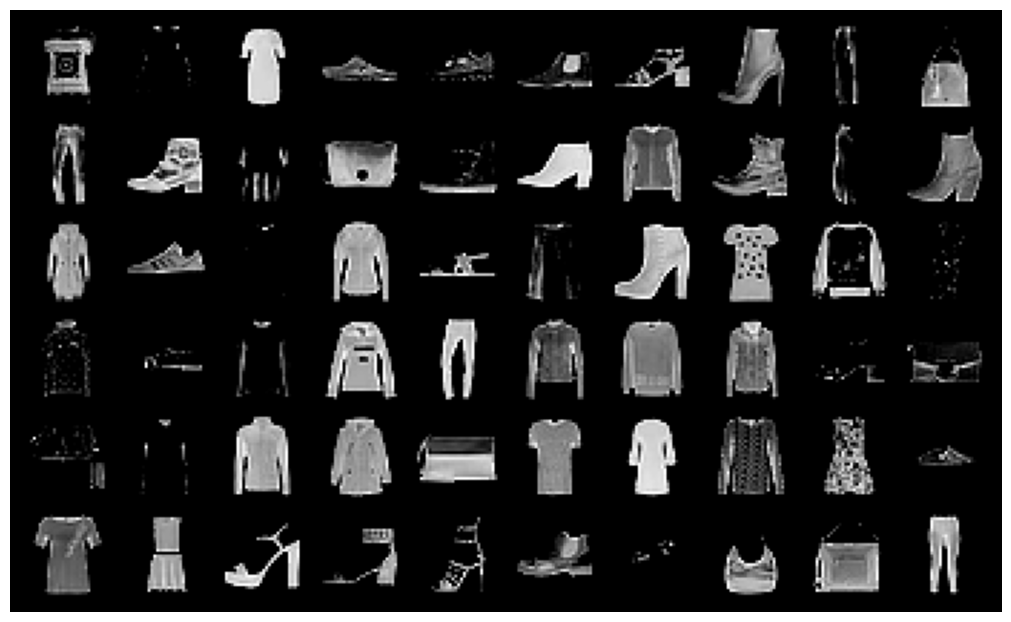

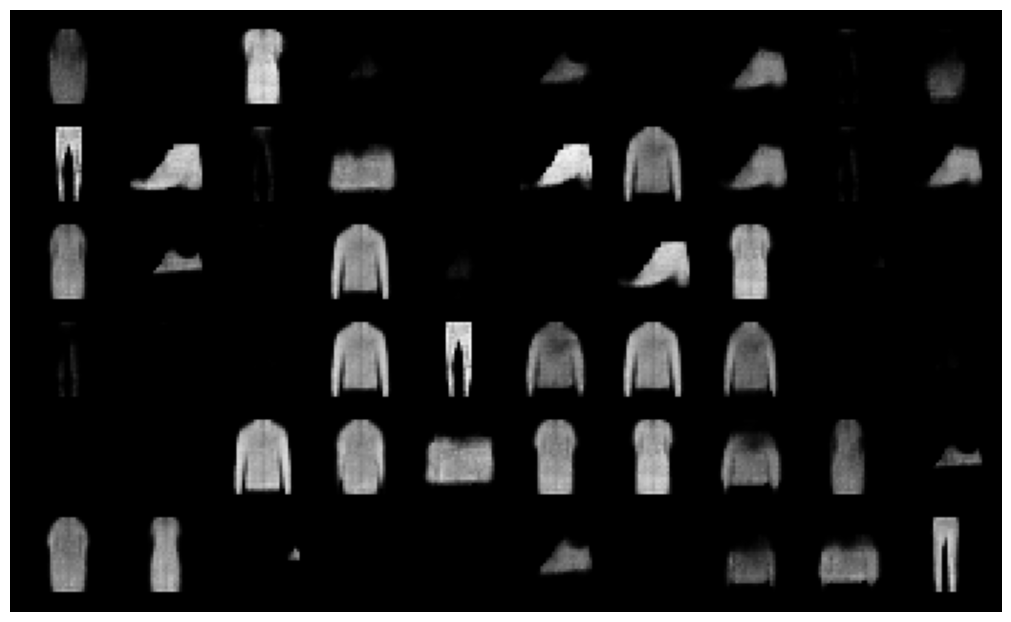

In [ ]:
model_2 = VAE(capacity=32, latent_dim=2).to(device)  # TODO: Instantiate the VAE model
learning_rate = 1e-3
# Instantiate the optimizer with the model's parameters and the defined learning rate
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)  # TODO
run_training(model_2, train_loader, vae_loss, optimizer, n_epochs=10)
images_columns = 10
images_rows    = 6

data_iterator = iter(train_loader)
images, labels = data_iterator._next_data()

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction
    images_recon,mean,logvar = model_2(images.to(device))

    show_grid(images_recon[0:(images_columns * images_rows)].cpu(), images_columns, images_rows)

100%|██████████| 10/10 [02:19<00:00, 13.94s/it]


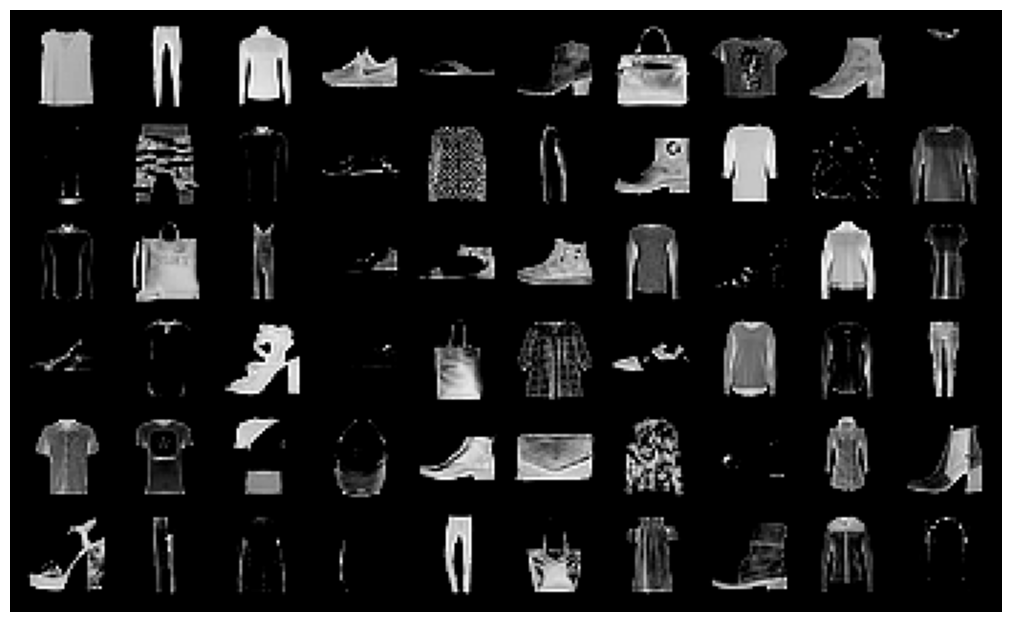

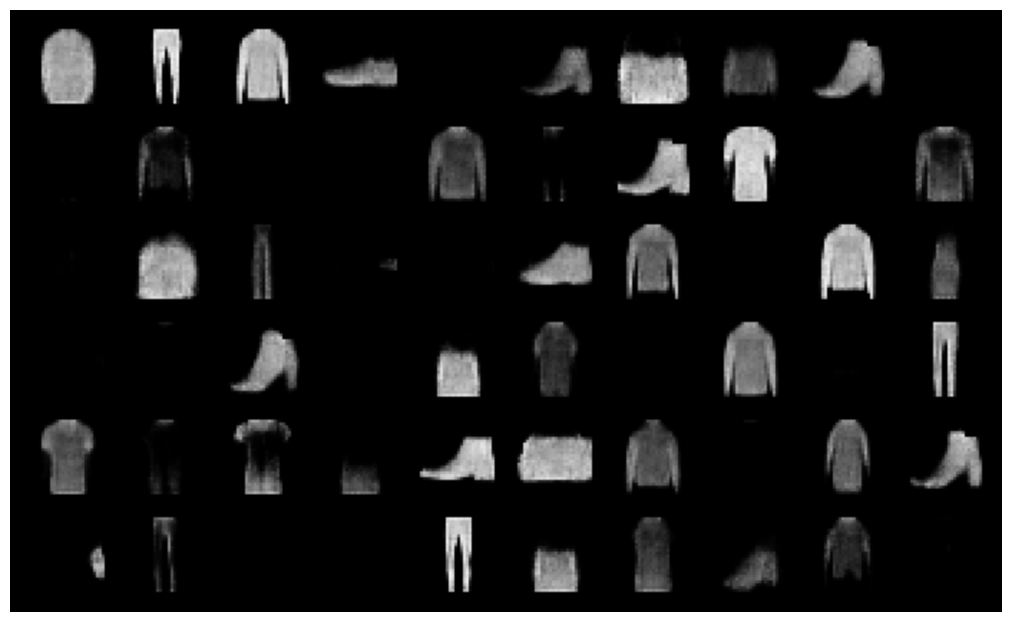

In [ ]:
model_4 = VAE(capacity=32, latent_dim=4).to(device)  # TODO: Instantiate the VAE model
learning_rate = 1e-3
# Instantiate the optimizer with the model's parameters and the defined learning rate
optimizer = optim.Adam(model_4.parameters(), lr=learning_rate)  # TODO
run_training(model_4, train_loader, vae_loss, optimizer, n_epochs=10)
images_columns = 10
images_rows    = 6

data_iterator = iter(train_loader)
images, labels = data_iterator._next_data()

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction
    images_recon,mean,logvar = model_4(images.to(device))

    show_grid(images_recon[0:(images_columns * images_rows)].cpu(), images_columns, images_rows)

100%|██████████| 10/10 [02:17<00:00, 13.73s/it]


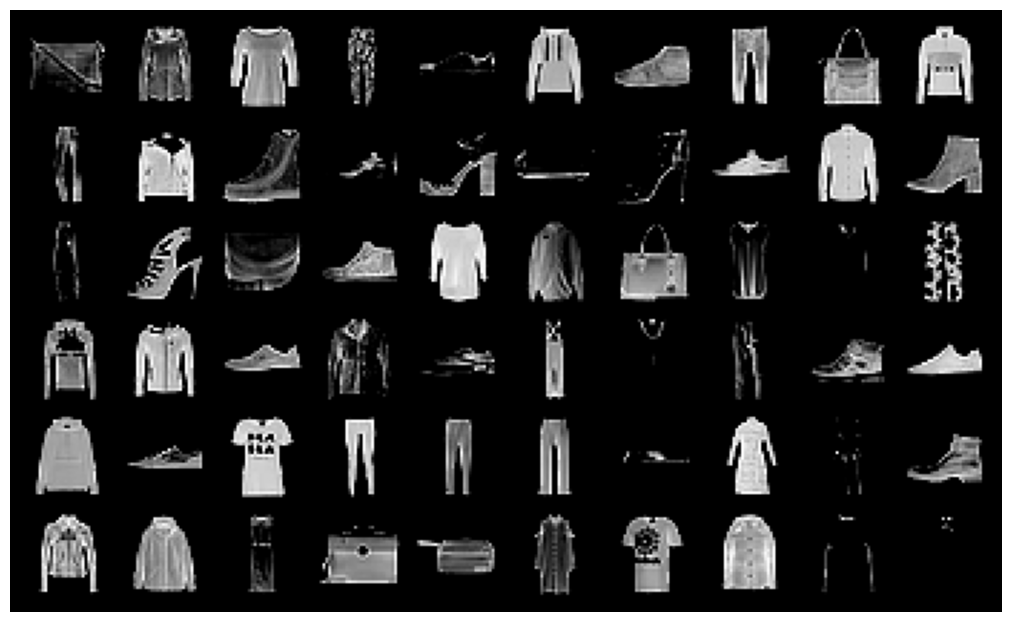

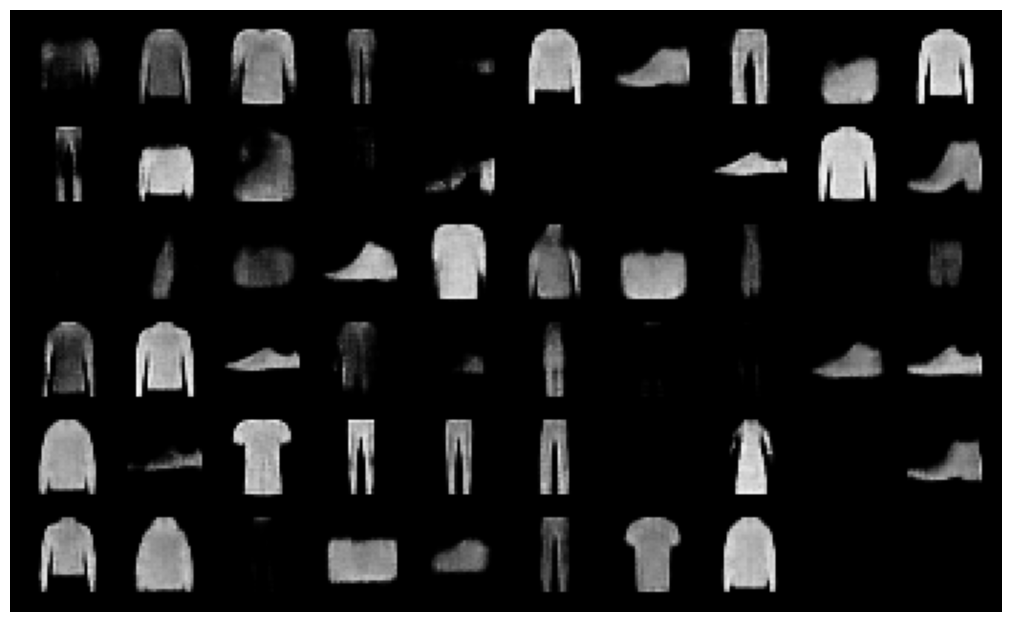

In [ ]:
model_8 = VAE(capacity=32, latent_dim=8).to(device)  # TODO: Instantiate the VAE model
learning_rate = 1e-3
# Instantiate the optimizer with the model's parameters and the defined learning rate
optimizer = optim.Adam(model_8.parameters(), lr=learning_rate)  # TODO
run_training(model_8, train_loader, vae_loss, optimizer, n_epochs=10)
images_columns = 10
images_rows    = 6

data_iterator = iter(train_loader)
images, labels = data_iterator._next_data()

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction
    images_recon,mean,logvar = model_8(images.to(device))

    show_grid(images_recon[0:(images_columns * images_rows)].cpu(), images_columns, images_rows)

100%|██████████| 10/10 [02:17<00:00, 13.79s/it]


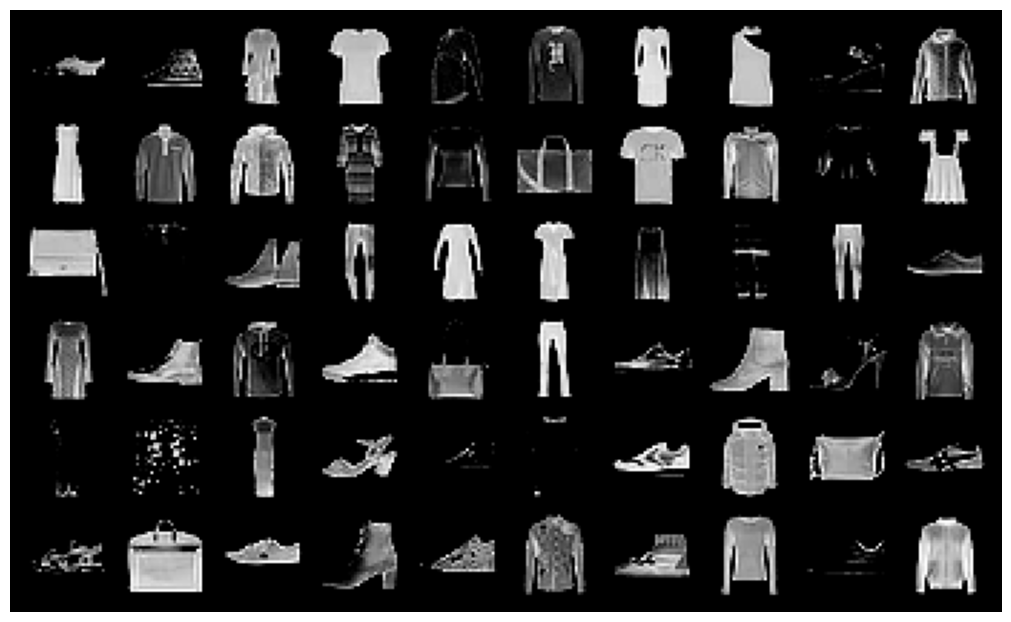

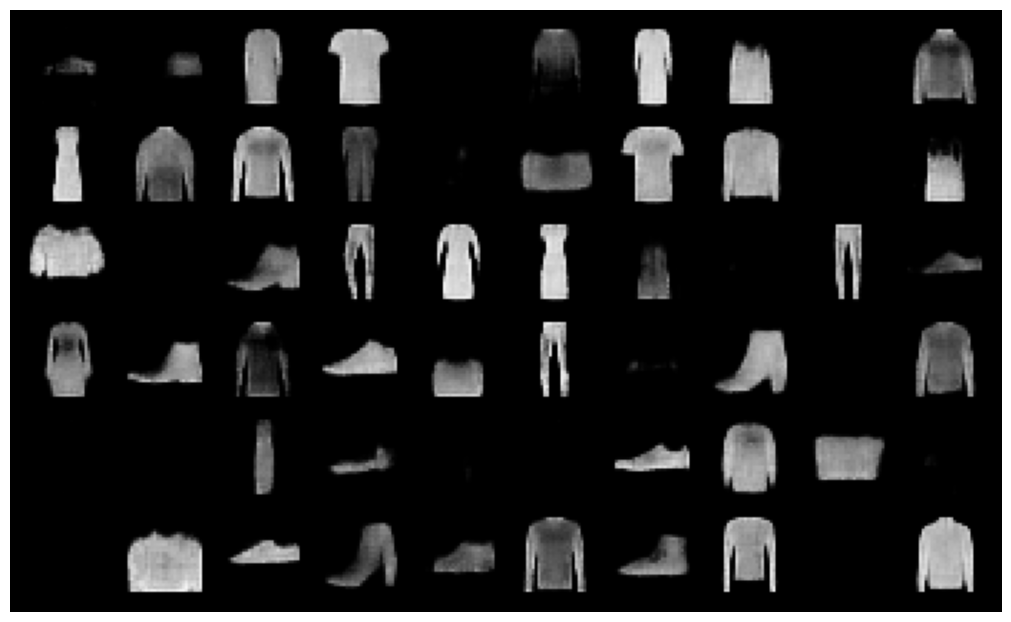

In [ ]:
model_16 = VAE(capacity=32, latent_dim=16).to(device)  # TODO: Instantiate the VAE model
learning_rate = 1e-3
# Instantiate the optimizer with the model's parameters and the defined learning rate
optimizer = optim.Adam(model_16.parameters(), lr=learning_rate)  # TODO
run_training(model_16, train_loader, vae_loss, optimizer, n_epochs=10)
images_columns = 10
images_rows    = 6

data_iterator = iter(train_loader)
images, labels = data_iterator._next_data()

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction
    images_recon,mean,logvar = model_16(images.to(device))

    show_grid(images_recon[0:(images_columns * images_rows)].cpu(), images_columns, images_rows)

100%|██████████| 10/10 [02:18<00:00, 13.84s/it]


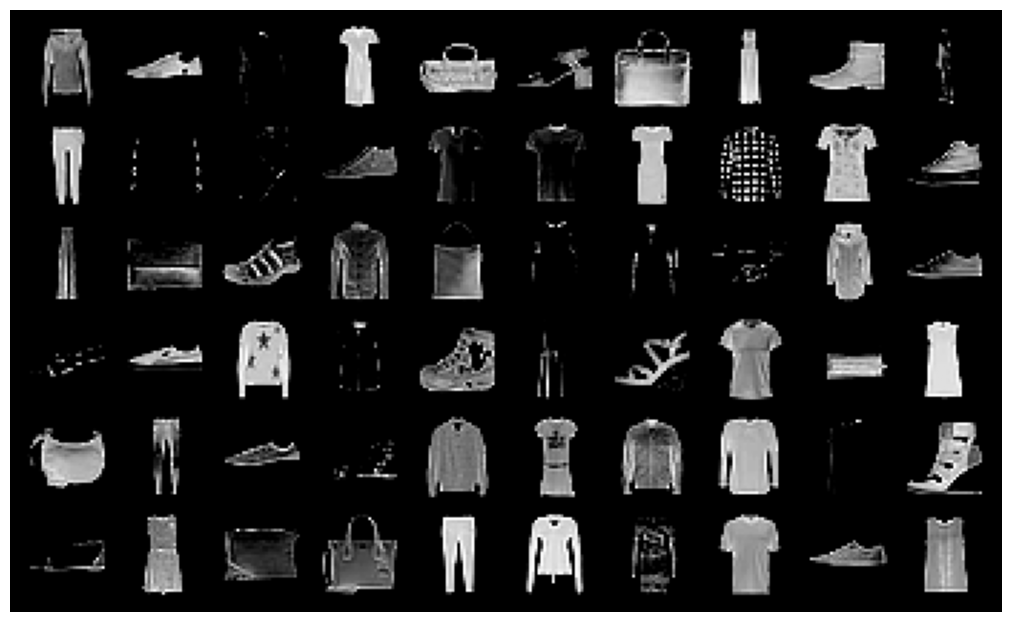

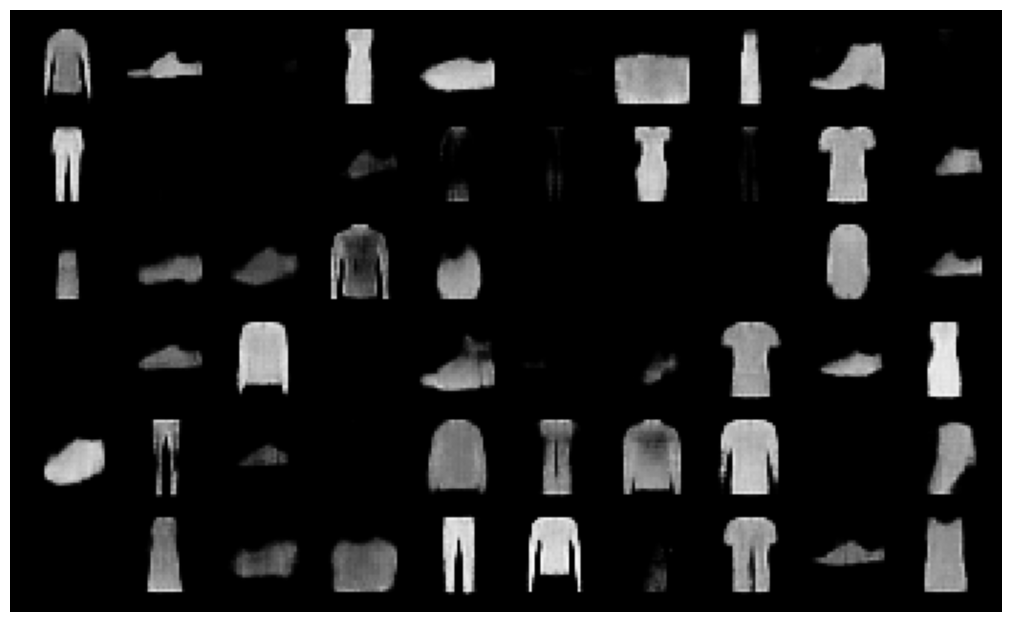

In [ ]:
model_32 = VAE(capacity=32, latent_dim=32).to(device)  # TODO: Instantiate the VAE model
learning_rate = 1e-3
# Instantiate the optimizer with the model's parameters and the defined learning rate
optimizer = optim.Adam(model_32.parameters(), lr=learning_rate)  # TODO
run_training(model_32, train_loader, vae_loss, optimizer, n_epochs=10)
images_columns = 10
images_rows = 6

data_iterator = iter(train_loader)
images, labels = data_iterator._next_data()

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction
    images_recon,mean,logvar = model_32(images.to(device))

    show_grid(images_recon[0:(images_columns * images_rows)].cpu(), images_columns, images_rows)

## Visualization of latent traversals

**TASK 4: Plot some latent traversals**

Latent traversal is a popular approach to visualize the disentangled latent representations. Given a bunch of variations in a single unit of the latent representation, it is expected that there is a change in a single factor of variation of the data while others are fixed. (See paper [Learning Disentangled Representations with Latent Variation Predictability](https://arxiv.org/abs/2007.12885))

Remember in the previous task you trained models with different latent dimensions. Each shape is encoded into a `latent_dim`-sized vector. In this task we want to see which shapes are reconstructed if we create a latent code where we set

- one of these dimensions (e.g. dim1=11) to different values ($x_i \in [-3,3]$)
- two of these dimensions (e.g. dim1=31, dim2=4) to different values ($x_i, x_j \in [-3,3]$)

while setting all other values of the latent code to $0$. Use the decoder of the VAE neural network to create images from these latent codes.

**TODO:** Create a 1 x 10 array plot for the first visualization and a 10 x 10 matrix plot for the second showing latent space travels.

**TODO:** Repeat the experiment, now setting the other dimensions of the vector to a random value in [-1,1] instead of zero. Write down what you observe.

Here are two examples.

1x10 traversal of one latent dimension

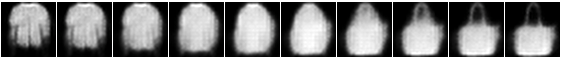

10x10 traversal of two latent dimensions

![10x10 traversal of two latent dimensions](https://i.imgur.com/hZXIYzv.png)

In [ ]:
def latent_traversal_one_dim(vae, latent_dim, dim=0, traversal_range=(-3, 3), num_steps=10, device='cuda'):
    """
    Traverses a single latent dimension and generates corresponding images.

    Args:
        vae (YourVAEClass): The trained VAE model containing the decode method.
        latent_dim (int): Dimensionality of the latent space.
        dim (int): The specific latent dimension to traverse.
        traversal_range (tuple): Range of values to traverse.
        num_steps (int): Number of steps in traversal.
        device (str): Device to perform computations on.
    """
    # Generate traversal values
    traversal_values = np.linspace(traversal_range[0], traversal_range[1], num_steps)

    # Initialize latent vectors with zeros
    latent_vectors = np.zeros((num_steps, latent_dim))

    # Set the chosen dimension to traversal values
    latent_vectors[:, dim] = traversal_values

    # Convert to torch tensor and move to device
    latent_vectors = torch.tensor(latent_vectors, dtype=torch.float32).to(device)

    # Decode the latent vectors using your VAE's decode method
    with torch.no_grad():
        generated_images = vae.decode(latent_vectors).cpu()

    # Reshape images: (batch_size, 1, 28, 28) -> (batch_size, 28, 28)
    generated_images = generated_images.view(-1, 28, 28)

    # Plotting
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps, 1))
    for i in range(num_steps):
        img = generated_images[i]  # Tensor on CPU
        img_np = img.numpy()  # Convert to NumPy
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{traversal_values[i]:.1f}", fontsize=8)
    plt.suptitle(f'Latent Traversal on Dimension {dim}')
    plt.tight_layout()
    plt.show()






In [ ]:
vae = run_training(model, train_loader, vae_loss, optimizer, n_epochs=10)
vae.eval()

100%|██████████| 10/10 [02:18<00:00, 13.82s/it]


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=10, bias=True)
  (fc_z): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

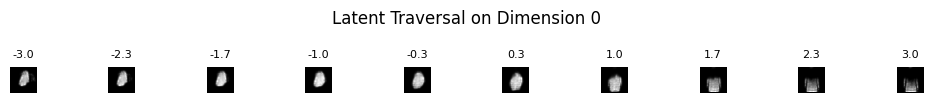

In [ ]:
latent_traversal_one_dim(vae, latent_dim, dim=0, device='cuda')

<ipython-input-52-564cae3dcf85>:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  latent_vectors = torch.tensor(latent_vectors, dtype=torch.float32).to(device)


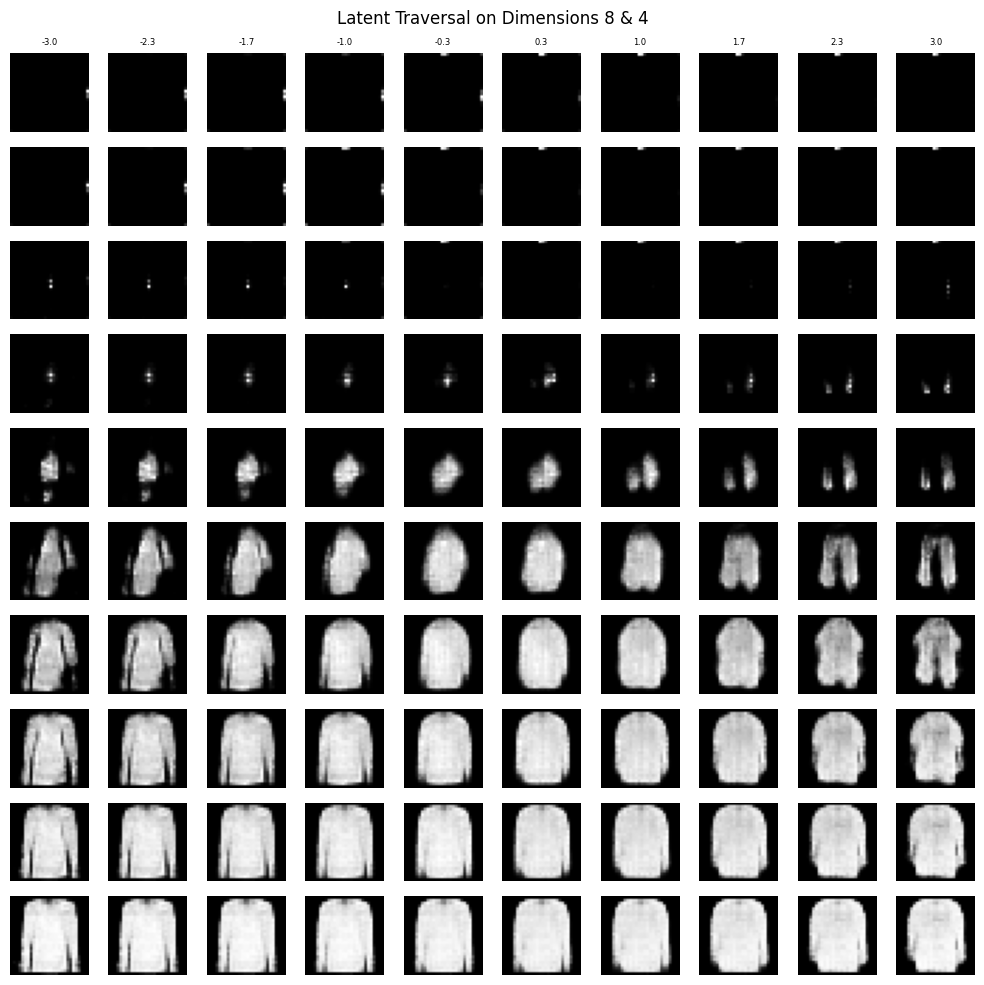

In [ ]:
def latent_traversal_two_dims(vae, latent_dim, dim1=0, dim2=1, traversal_range=(-3, 3), num_steps=10, device=device):
    """
    Traverses two latent dimensions and generates corresponding images.

    Args:
        vae (YourVAEClass): The trained VAE model containing the decode method.
        latent_dim (int): Dimensionality of the latent space.
        dim1 (int): The first latent dimension to traverse.
        dim2 (int): The second latent dimension to traverse.
        traversal_range (tuple): Range of values to traverse.
        num_steps (int): Number of steps in traversal for each dimension.
        device (str): Device to perform computations on.
    """
    # Generate traversal values
    traversal_values = np.linspace(traversal_range[0], traversal_range[1], num_steps)

    # Initialize latent vectors
    latent_vectors = []
    for val1 in traversal_values:
        for val2 in traversal_values:
            vector = np.zeros(latent_dim)
            vector[dim1] = val1
            vector[dim2] = val2
            latent_vectors.append(vector)

    latent_vectors = torch.tensor(latent_vectors, dtype=torch.float32).to(device)

    # Decode the latent vectors using your VAE's decode method
    with torch.no_grad():
        generated_images = vae.decode(latent_vectors).cpu()

    # Reshape images: (batch_size, 1, 28, 28) -> (batch_size, 28, 28)
    generated_images = generated_images.view(-1, 28, 28)

    # Plotting
    fig, axes = plt.subplots(num_steps, num_steps, figsize=(num_steps, num_steps))
    idx = 0
    for i in range(num_steps):
        for j in range(num_steps):
            axes[i, j].imshow(generated_images[idx], cmap='gray')
            axes[i, j].axis('off')
            # Labeling axes for the first row and first column
            if i == 0:
                axes[i, j].set_title(f"{traversal_values[j]:.1f}", fontsize=6)
            if j == 0:
                axes[i, j].set_ylabel(f"{traversal_values[i]:.1f}", fontsize=6)
            idx += 1
    plt.suptitle(f'Latent Traversal on Dimensions {dim1} & {dim2}')
    plt.tight_layout()
    plt.show()

# Example Usage:
latent_traversal_two_dims(vae, latent_dim, dim1=8, dim2=4, device=device)


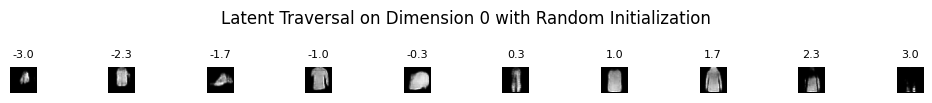

In [ ]:
def latent_traversal_one_dim_random(vae, latent_dim, dim=0, traversal_range=(-3, 3), num_steps=10, device=device):
    """
    Traverses a single latent dimension with other dimensions set to random values.

    Args:
        vae (YourVAEClass): The trained VAE model containing the decode method.
        latent_dim (int): Dimensionality of the latent space.
        dim (int): The specific latent dimension to traverse.
        traversal_range (tuple): Range of values to traverse.
        num_steps (int): Number of steps in traversal.
        device (str): Device to perform computations on.
    """
    # Generate traversal values
    traversal_values = np.linspace(traversal_range[0], traversal_range[1], num_steps)

    # Initialize latent vectors with random values
    latent_vectors = np.random.uniform(-1, 1, (num_steps, latent_dim))

    # Set the chosen dimension to traversal values
    latent_vectors[:, dim] = traversal_values

    # Convert to torch tensor and move to device
    latent_vectors = torch.tensor(latent_vectors, dtype=torch.float32).to(device)

    # Decode the latent vectors using your VAE's decode method
    with torch.no_grad():
        generated_images = vae.decode(latent_vectors).cpu()

    # Reshape images: (batch_size, 1, 28, 28) -> (batch_size, 28, 28)
    generated_images = generated_images.view(-1, 28, 28)

    # Plotting
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps, 1))
    for i in range(num_steps):
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{traversal_values[i]:.1f}", fontsize=8)
    plt.suptitle(f'Latent Traversal on Dimension {dim} with Random Initialization')
    plt.tight_layout()
    plt.show()

# Example Usage:
latent_traversal_one_dim_random(vae, latent_dim, dim=0, device=device)


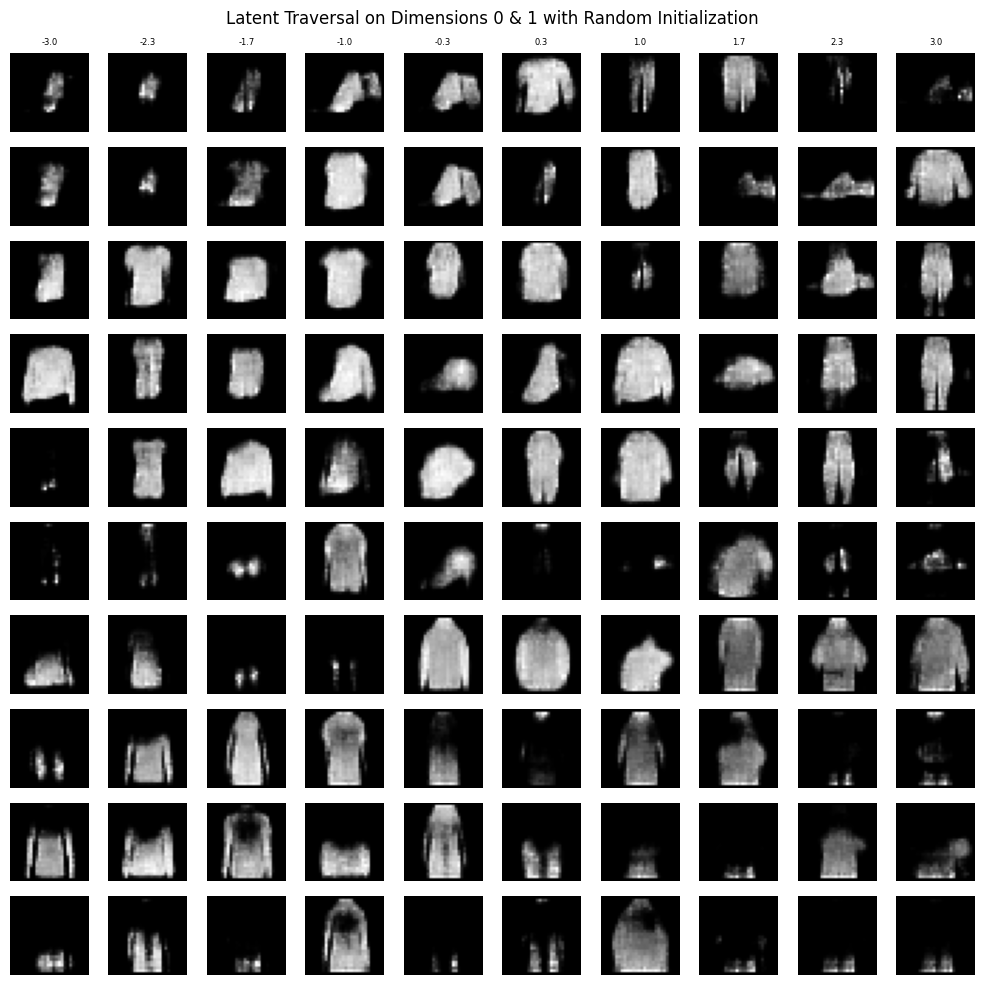

In [ ]:
def latent_traversal_two_dims_random(vae, latent_dim, dim1=0, dim2=1, traversal_range=(-3, 3), num_steps=10, device=device):
    """
    Traverses two latent dimensions with other dimensions set to random values.

    Args:
        vae (YourVAEClass): The trained VAE model containing the decode method.
        latent_dim (int): Dimensionality of the latent space.
        dim1 (int): The first latent dimension to traverse.
        dim2 (int): The second latent dimension to traverse.
        traversal_range (tuple): Range of values to traverse.
        num_steps (int): Number of steps in traversal for each dimension.
        device (str): Device to perform computations on.
    """
    # Generate traversal values
    traversal_values = np.linspace(traversal_range[0], traversal_range[1], num_steps)

    # Initialize latent vectors with random values
    latent_vectors = []
    for val1 in traversal_values:
        for val2 in traversal_values:
            vector = np.random.uniform(-1, 1, latent_dim)
            vector[dim1] = val1
            vector[dim2] = val2
            latent_vectors.append(vector)

    latent_vectors = torch.tensor(latent_vectors, dtype=torch.float32).to(device)

    # Decode the latent vectors using your VAE's decode method
    with torch.no_grad():
        generated_images = vae.decode(latent_vectors).cpu()

    # Reshape images: (batch_size, 1, 28, 28) -> (batch_size, 28, 28)
    generated_images = generated_images.view(-1, 28, 28)

    # Plotting
    fig, axes = plt.subplots(num_steps, num_steps, figsize=(num_steps, num_steps))
    idx = 0
    for i in range(num_steps):
        for j in range(num_steps):
            axes[i, j].imshow(generated_images[idx], cmap='gray')
            axes[i, j].axis('off')
            # Labeling axes for the first row and first column
            if i == 0:
                axes[i, j].set_title(f"{traversal_values[j]:.1f}", fontsize=6)
            if j == 0:
                axes[i, j].set_ylabel(f"{traversal_values[i]:.1f}", fontsize=6)
            idx += 1
    plt.suptitle(f'Latent Traversal on Dimensions {dim1} & {dim2} with Random Initialization')
    plt.tight_layout()
    plt.show()

# Example Usage:
latent_traversal_two_dims_random(vae, latent_dim, dim1=0, dim2=1, device=device)


### Visualize class labels in latent space

**TASK 5: Visualize class labels in latent space**

First create a new VAE-model with a 2d latent space on the full training data set. Then project all the images of the training set into the 2d latent space keeping track of their class labels. Use a 2d scatter plot to visualize the resulting latent space vectors and different colors for their labels.

#### Train 2d latent space model

In [ ]:
# TODO
model = VAE(capacity,2).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = vae_loss
run_training(model, train_loader, loss, optimizer, n_epochs=10)

100%|██████████| 10/10 [02:26<00:00, 14.66s/it]


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=2, bias=True)
  (fc_z): Linear(in_features=2, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

#### Visualize classes

In [ ]:
# TODO
def plot_2d_latent_space(z,labels):

    my_dict = {}
    my_dict[0] = 'Tshirt'
    my_dict[1] = 'trousers'
    my_dict[2] = 'pullover'
    my_dict[3] = 'dress'
    my_dict[4] = 'coat'
    my_dict[5] = 'sandal'
    my_dict[6] = 'shirt'
    my_dict[7] = 'sneaker'
    my_dict[8] = 'bag'
    my_dict[9] = 'mydic'

    z = z.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()

    for i in range(10):
        a = z[labels == i]

        plt.scatter(a[:,0], a[:,1],label = my_dict[i], cmap='rainbow')
    #print(labels[i])

    plt.legend(loc='upper center', bbox_to_anchor=(2, 1.05),
          ncol=3, fancybox=True, shadow=True)

    plt.figure(figsize=(10,10))
    plt.show()


<ipython-input-56-d9e69da25e5f>:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(a[:,0], a[:,1],label = my_dict[i], cmap='rainbow')


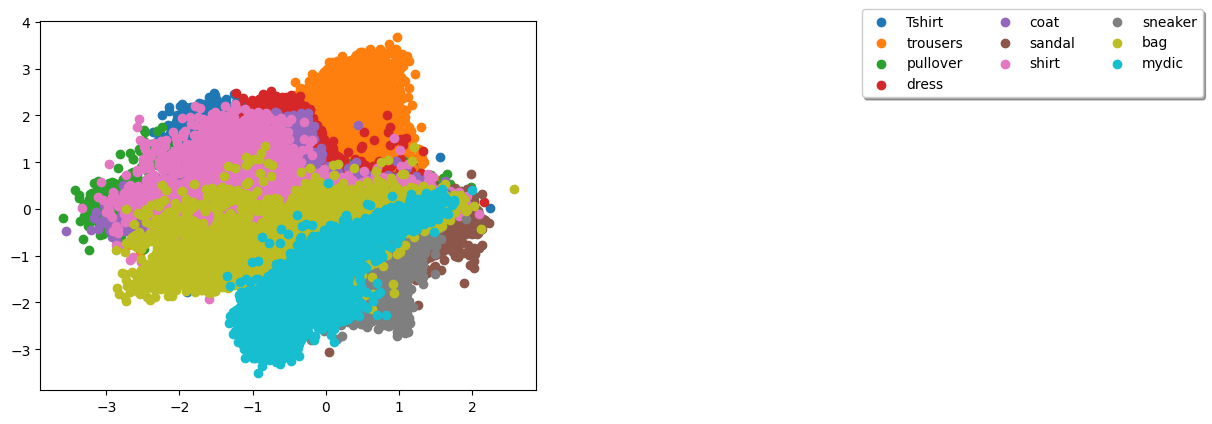

<Figure size 1000x1000 with 0 Axes>

In [ ]:
loader = torch.utils.data.DataLoader(train_dataset, batch_size= len(train_loader.dataset), shuffle=True)

#for i, (images, labels) in enumerate(loader):
images,labels = next(iter(loader))
images = images.to(device)
z = model.encode(images)
if isinstance(z, tuple):
    z = z[0]  # Adjust based on what the tuple contains

# Move the encoded representation to the correct device
z = z.to(device)

#images,labels = next(iter(train_loader)
plot_2d_latent_space(z,labels)

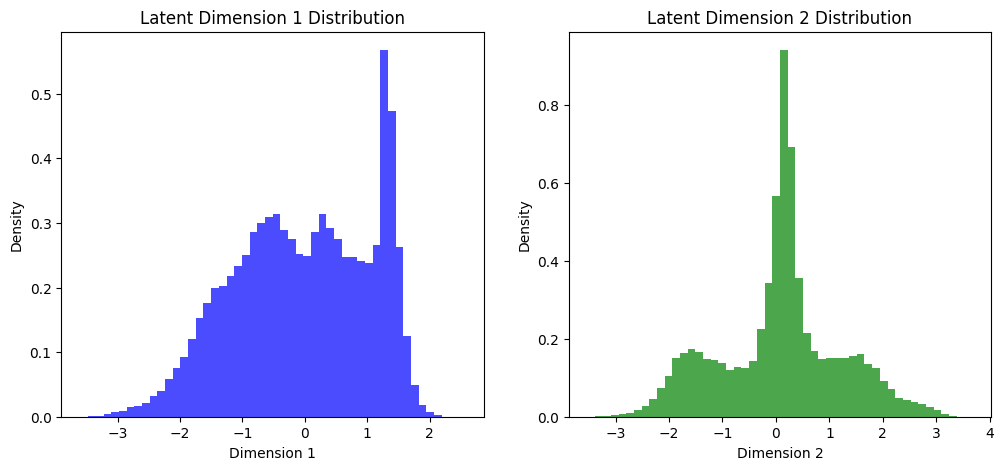

In [ ]:
def plot_latent_distributions(z):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(z[:, 0], bins=50, density=True, alpha=0.7, color='blue')
    plt.title('Latent Dimension 1 Distribution')
    plt.xlabel('Dimension 1')
    plt.ylabel('Density')

    plt.subplot(1, 2, 2)
    plt.hist(z[:, 1], bins=50, density=True, alpha=0.7, color='green')
    plt.title('Latent Dimension 2 Distribution')
    plt.xlabel('Dimension 2')
    plt.ylabel('Density')

    plt.show()


# Optionally, visualize the distribution of each latent dimension
plot_latent_distributions(z.cpu().detach().numpy())


#### Questions

- Do images of the same class cluster in latent space?
- Do the data points in latent space look like a normal distribution?

**Your answer here:**
   1. Yes, we can see them forming a good cluster. Maybe more than the latent_dim 2, together with a good number of epoch and better learning could a little more than this.
   2. They are approximately, trying to be normally distributed. Again maybe with a better training we would see that

# Appendix *(Optional)*

Use standard MNIST or CIFAR-10 instead of fashion MNIST.

In [ ]:
transform = transforms.Compose([
   transforms.Resize(image_size),
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(data_dir, train=False, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.04MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

